##### BNS-vs-two-channel-rprocess.ipynb
### *hypothesis testing on one- vs two-channel galactic chemical evolution models, conditioned on galactic r-process abundance observations*

this notebook plots posterior samples X ~ P(X|d) in the integrated second-channel contribution, conditioned on r-process abundance measurements from galactic stellar spectra, merger rate constraints from gravitational-wave surveys, ejecta expectations from numerical relativity and information about short gamma-ray burst delay times, and computes the evidence ratio between the one- (X=0) and two-channel (X>0) hypotheses

##### philippe landry (pgjlandry@gmail.com) 02/2024

In [11]:
# import packages

import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal, gaussian_kde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from etc.rProcessUtils import rho_MW
from etc.rProcessChemicalEvolution import rproc_evolution

In [3]:
# user input

NSAMP = 500 # number of delay time distribution parameter samples to draw

DTDPATH = 'etc/Zevin22_sgrb_dtd.dat' # path to delay time distribution parameter samples
EJPATH = 'etc/mej_rate_lcehl_psr+gw+nicer.dat' # path to rate and ejecta samples

OBSPATH = 'etc/Battistini16_disk.csv' # path to disk star observations
OBSPATH2 = 'etc/SAGA_MP.csv' # path to disk+halo star observations

SOLARPATH = 'etc/Arnould07_solar_rprocess.dat' # path to solar r-process abundances

FEH_MIN, FEH_MAX = (-3.,0.5)
NFEH = int((FEH_MAX-FEH_MIN)/0.05) # Fe grid spacing for confidence intervals

NSTP = 3 # number of subdivisions per time step in chemical evolution integration

In [6]:
# load DTD parameter and rate-mej samples, and sample in X

alpha, tdmin, tdmax = np.loadtxt(DTDPATH, unpack=True, skiprows=1) # [], [yr], [yr]
tdmin = tdmin/1e9 # convert to Gyr
idxs = np.random.choice(range(len(alpha)),NSAMP,False) # jointly sample in alpha, tmin
alphas = alpha[idxs]
tdmins = tdmin[idxs]

mej_dyn, mej_dsk, rate = np.loadtxt(EJPATH, unpack=True) # [Msun], [Msun], [MW^-1 Myr^-1]
mej = mej_dyn + mej_dsk
rate = rate*(1e9*rho_MW)/1e6 # convert to Gpc^-3 yr^-1
idxs = np.random.choice(range(len(mej)),NSAMP,False) # jointly sample in rate, mej
rates = rate[idxs]
mejs = mej[idxs]

Xs = np.random.uniform(0.,1.,NSAMP)

samples = pd.DataFrame(np.column_stack((alphas,np.log10(tdmins*1e3),rates*mejs*1e6/(1e9*rho_MW),Xs))) # [], [Myr], [MW^-1 Myr^-1]
samples.columns = ['alpha','log10tmin','ratemej','X']

In [7]:
# load disk star observations and make gaussian likelihood model for each datapoint

FeHs, EuFes, FeH_errs, EuFe_errs = np.loadtxt(OBSPATH, unpack=True, delimiter=',', skiprows=1)

like_means = []
like_stds = []

for fe,eu,fe_err,eu_err in zip(FeHs, EuFes, FeH_errs, EuFe_errs):

    mean = np.array([fe,eu])
    std = np.array([[fe_err,0.],[0.,eu_err]])
    
    like_means += [mean]
    like_stds += [std]   
    
like_funcs = [multivariate_normal(mean,std) for mean,std in zip(like_means,like_stds)]

# load disk+halo star observations for plotting

FeHs2, EuFes2, FeH_errs2, EuFe_errs2 = np.loadtxt(OBSPATH2, unpack=True, delimiter=',', skiprows=1)

In [8]:
# compute predicted galactic r-process enrichment histories and their likelihood, given the stellar observations

FeH_grid = np.linspace(FEH_MIN,FEH_MAX,NFEH)
loglike, EuFe_pts = [], []

for i,(alpha,tdmin,rate,mej,X) in tqdm(enumerate(zip(alphas,tdmins,rates,mejs,Xs))):
    
    FeH_track, EuFe_track = rproc_evolution(rate,mej,-alpha,tdmin,X,0.5,NSTP)
    
    track = np.column_stack((FeH_track,EuFe_track))
    track = track[np.where(track[:,1] >= -5.)[0][0]:]
    track = track[~np.isnan(track[:,1])]
    loglikes = [np.log(np.trapz(like_func.pdf(track),track[:,0])) for like_func in like_funcs]
    loglike += [np.sum(loglikes)]
    
    EuFe_of_FeH = interp1d(FeH_track,EuFe_track,bounds_error=False)
    EuFe_pts += [EuFe_of_FeH(FeH_grid)]
    
EuFe_pts = np.array(EuFe_pts)

0it [00:00, ?it/s]/home/philippe.landry/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/philippe.landry/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354: RuntimeWarning: invalid value encountered in divide
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:362: RuntimeWarning: invalid value encountered in divide
  result = C * heaviside(t-tmin,1.) / t**b
/home/philippe.landry/bns-dtd-rproc/etc/rProcessUtils.py:354: RuntimeWarning: invalid value encountered in power
  result = C * heaviside(t-tmin,1.) / t**b
500it [05:27,  1.52it

In [9]:
# calculate abundance history confidence envelopes

CLS = [0.68,0.9]
md, qs = [], []

def wtquantile(xs,qs,wts=[]):
    
    nan_idxs = np.isnan(xs)
    xs = np.array(xs[~nan_idxs])
    
    num_xs = len(xs)
    qs = np.array(qs, ndmin=1)
    if len(xs) < 1: return np.full(2*len(qs),np.nan)
    elif len(xs) == 1: return np.full(2*len(qs),xs[0])
    if len(wts) < 1: wts = np.full(num_xs, 1.)
    else: wts = np.array(wts[~nan_idxs])
    
    ps = wts/np.sum(wts)
    xs_sorted,ps_sorted = zip(*sorted(list(zip(xs,ps)),reverse=False))

    Ps = np.cumsum(ps_sorted)

    idxs_lb = np.array([np.where(Ps >= (1.-q)/2.)[0][0] for q in qs])
    idxs_ub = np.array([np.where(Ps >= 1.-(1.-q)/2.)[0][0] for q in qs])
    xs_sorted = np.array(xs_sorted)

    return list(xs_sorted[idxs_lb])+list(xs_sorted[idxs_ub])

for i in range(NFEH):
    
    qs += [wtquantile(EuFe_pts[:,i],[0.68,0.9],np.exp(loglike))]
    md += [wtquantile(EuFe_pts[:,i],0.,np.exp(loglike))]
    
qs = np.array(qs)

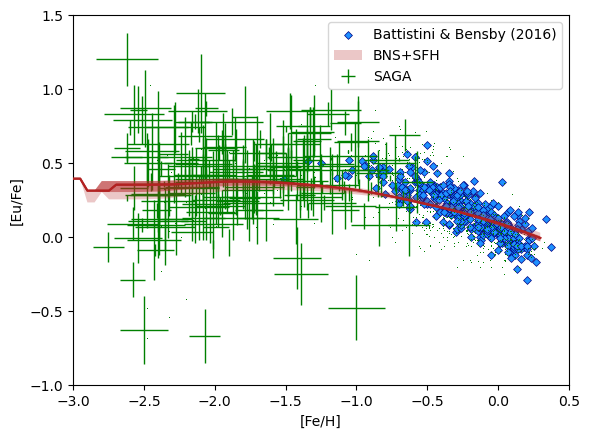

In [10]:
# plot EuFe vs FeH tracks conditioned on stellar observations

plt.figure(figsize=(6.4,4.8))

plt.errorbar(FeHs2, EuFes2, xerr=[FeH_errs2,FeH_errs2], yerr=[EuFe_errs2,EuFe_errs2], c='g', fmt=',', lw=1, label='SAGA')
plt.scatter(FeHs, EuFes,marker='D',facecolor='dodgerblue',edgecolor='navy', s=16, lw=0.5, label='Battistini & Bensby (2016)')

plt.fill_between(FeH_grid,qs[:,1],qs[:,3],facecolor='firebrick',edgecolor=None,alpha=0.25, label='BNS+SFH',zorder=10) # 90% CI
plt.fill_between(FeH_grid,qs[:,0],qs[:,2],facecolor='firebrick',edgecolor=None,alpha=0.5,zorder=10) # 68% CI

plt.plot(FeH_grid,md,c='firebrick',zorder=10) # median

plt.xlim(-3.,0.5)
plt.ylim(-1.,1.5)
plt.xlabel('[Fe/H]')
plt.ylabel('[Eu/Fe]')
plt.legend(frameon=True,loc='upper right')
plt.show()

In [32]:
# compute Bayes factor between one- and two-channel models as Savage-Dickey density ratio at X=0

prior_of_X = gaussian_kde(Xs)
post_of_X = gaussian_kde(Xs,weights=np.exp(loglike))

bf = float(post_of_X(0.)/prior_of_X(0.))

print('The evidence ratio (Bayes factor) between the one- and two-channel models is {0:.1e}.'.format(bf))

The evidence ratio (Bayes factor) between the one- and two-channel models is 4.4e-03.
